In [1]:
import nest
import numpy as np
# For computing the power spectrum.
from scipy import signal

import matplotlib.pyplot as plt


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.4
 Built: May 18 2023 09:38:28

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
%matplotlib inline

In [3]:
class NEST_simulator:
    """
    Class to initialize and store the default NEST simulator.
    """
    
    def __init__(self):
        nest.ResetKernel()

        # Set simulation kernel
        nest.SetKernelStatus({
          "local_num_threads": 1,
          "resolution": 0.1,
          "rng_seed": 1
        })

        # Create nodes
        self.n1 = nest.Create("iaf_psc_alpha", 300, params={
          "C_m": 30,
          "E_L": -70,
          "V_reset": -70,
          "V_th": -60,
          "t_ref": 2,
          "tau_m": 20,
          "tau_syn_ex": 1,
          "tau_syn_in": 10,
        })
        self.n2 = nest.Create("iaf_psc_alpha", 500, params={
          "C_m": 30,
          "E_L": -70,
          "V_reset": -70,
          "V_th": -60,
          "t_ref": 2,
          "tau_m": 20,
          "tau_syn_ex": 1,
          "tau_syn_in": 10,
        })
        self.pg1 = nest.Create("poisson_generator", 1, params={
          "rate": 800,
        })
        self.sr1 = nest.Create("spike_recorder", 1)
        self.vm1 = nest.Create("voltmeter", 1)
        self.pg2 = nest.Create("poisson_generator", 1, params={
          "rate": 800,
          "start": 1000,
          "stop": 3000,
        })
        self.dc1 = nest.Create("dc_generator", 1, params={
          "amplitude": -180,
          "start": 2000,
          "stop": 3000,
        })
        self.vm2 = nest.Create("voltmeter", 1)
        self.sr2 = nest.Create("spike_recorder", 1)

        # Connect nodes
        nest.Connect(self.n1, self.n2, conn_spec={
          "rule": "fixed_indegree",
          "indegree": 50,
        }, syn_spec={ 
          "weight": 30,
          "delay": 5,
        })
        nest.Connect(self.n1, self.n1, conn_spec={
          "rule": "fixed_indegree",
          "indegree": 50,
        }, syn_spec={ 
          "weight": 50,
          "delay": 2,
        })
        nest.Connect(self.n2, self.n2, conn_spec={
          "rule": "fixed_indegree",
          "indegree": 30,
        }, syn_spec={ 
          "weight": -5,
          "delay": 2,
        })
        nest.Connect(self.n2, self.n1, conn_spec={
          "rule": "fixed_indegree",
          "indegree": 30,
        }, syn_spec={ 
          "weight": -15,
          "delay": 5,
        })
        nest.Connect(self.pg1, self.n1, syn_spec={ 
          "weight": 65,
        })
        nest.Connect(self.pg1, self.n2, syn_spec={ 
          "weight": 40,
        })
        nest.Connect(self.vm1, self.n1)
        nest.Connect(self.pg2, self.n2, syn_spec={ 
          "weight": -5,
        })
        nest.Connect(self.dc1, self.n1)
        nest.Connect(self.n1, self.sr1)
        nest.Connect(self.vm2, self.n2)
        nest.Connect(self.n2, self.sr2)

Initialize nest simulator.

In [4]:
simulator = NEST_simulator()


Jun 25 22:30:17 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.


In [5]:
SIM_LENGTH = 3000

def run_simulation(sim_time=SIM_LENGTH):
    """
    Runs simulation of the predefine NEST simulator.
    
    Returns `sr1.events, sr2.events, vm1.events, vm2.events`. Where `sr1` and `sr2` are strike recorders for STN and GPe. 
    And `vm1` and `vm2` are voltmeters for STN and GPe.
    """
    nest.Simulate(sim_time)

    return simulator.sr1.events, simulator.sr2.events, simulator.vm1.events, simulator.vm2.events

Run simulation with the default setup.

In [6]:
sr_stn, sr_gpe, _, _ = run_simulation()


Jun 25 22:30:17 NodeManager::prepare_nodes [Info]: 
    Preparing 807 nodes for simulation.

Jun 25 22:30:17 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 807
    Simulation time (ms): 3000
    Number of OpenMP threads: 1
    Number of MPI processes: 1

Jun 25 22:30:19 SimulationManager::run [Info]: 
    Simulation finished.


Print simulation information.

In [7]:
gpe_start = int(simulator.pg2.start)
dbs_start = int(simulator.dc1.start)


print(f"Simulation duration: {SIM_LENGTH} ms")
print()
print("Start times")
print("-------------------------")
print(f"No additional input: {0} ms")
print(f"GPe increased: {gpe_start} ms")
print(f"Deep Brain Simulation (DBS): {dbs_start} ms")

Simulation duration: 3000 ms

Start times
-------------------------
No additional input: 0 ms
GPe increased: 1000 ms
Deep Brain Simulation (DBS): 2000 ms


# Raster plot of neuronal activity

In [8]:
def plot_raster_neuronal_activity(stn, gpe, ax=None, title="", filename=None):
    """
    Plots raster plot of neuronal activity for `stn` population and `gpe` 
    population in time.
    """

    # In case we don't want to use plot as subplots.
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 4))
    
    ax.scatter(stn["times"], stn["senders"], marker=".", label="STN")
    ax.scatter(gpe["times"], gpe["senders"], marker=".", label="GPe")

    ax.set_title(title)
    ax.set_xlabel("Time [ms]")
    ax.set_ylabel("Neuron")
    ax.legend()

    if filename:
        plt.savefig(filename)

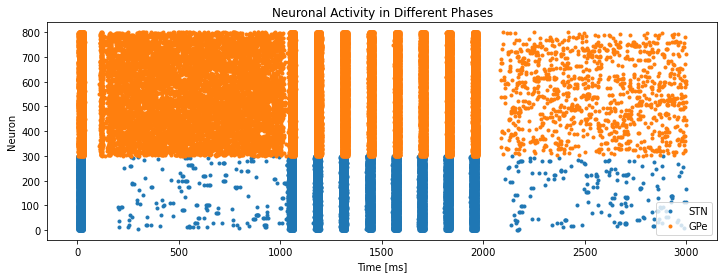

In [9]:
plot_raster_neuronal_activity(sr_stn, sr_gpe, title="Neuronal Activity in Different Phases")#, filename="raster_spikes.pdf")

# Mean Firing rate

In [10]:
T = 10

def compute_mean_firing_rates(spike_times, population_size, interval_size=T):
    """
    Computes mean firing rates from `spike_times` based on `population_size` and `interval_size` of the mean computation.
    
    Returns array of mean firing rates in each ms of the simulation.
    """
    
    def mean_firing_rate(spike_times, start, end, population_size):
        """
        Computes mean firing rate for the specific interval from `spike_times`.
        """
        
        return (np.sum((spike_times > start) & (spike_times < end)) / (end - start)) / population_size
    
    return np.array([mean_firing_rate(spike_times, start, start + T, population_size) for start in range(0, SIM_LENGTH)])

In [11]:
def plot_mean_firing_rates(stn, gpe, title="", filename=None):
    """
    Plots mean firing rate of `stn` and `gpe` population in time.
    """
    
    plt.figure(figsize=(12,4))
    plt.plot(stn, label="STN")
    plt.plot(gpe, label="GPe")
    
    plt.title(title)
    plt.xlabel("Time [ms]")
    plt.ylabel("Mean Firing Rate [spike/ms]")
    plt.legend()
    
    if filename:
        plt.savefig(filename)

In [12]:
stn_mean_firing_rate = compute_mean_firing_rates(sr_stn["times"], len(simulator.n1))
gpe_mean_firing_rate = compute_mean_firing_rates(sr_gpe["times"], len(simulator.n2))

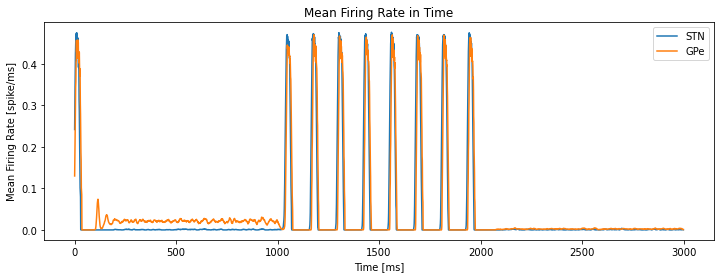

In [13]:
plot_mean_firing_rates(stn_mean_firing_rate, gpe_mean_firing_rate, title="Mean Firing Rate in Time")#, filename="mean_firing_rate.pdf")

# Power Spectrum

In [14]:
def plot_spectrogram(mean_firing_rates, nperseg_range=range(20, 200, 20), filename=None):
    """
    Plots spectrogram from the `mean_firing_rates` for different values of segment length defined by `nperseg_range`. 
    """
    
    # Determine the shape of the subplots.
    num_subplots = len(nperseg_range)
    nrows = int(np.sqrt(num_subplots))
    ncols = int(np.ceil(num_subplots / nrows))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 12))
    fig.tight_layout(pad=3.0)

    for i, nperseg in enumerate(nperseg_range):
        ax = axes[i // ncols, i % ncols] if num_subplots > 1 else axes
        f, t, Sxx = signal.spectrogram(mean_firing_rates, nperseg=nperseg)
        ax.pcolormesh(t, f, Sxx, shading='gouraud')
        ax.set_xlabel('Time')
        ax.set_ylabel('Frequency')
        ax.set_title('nperseg = {}'.format(nperseg))
        
    if filename:
        plt.savefig(filename)

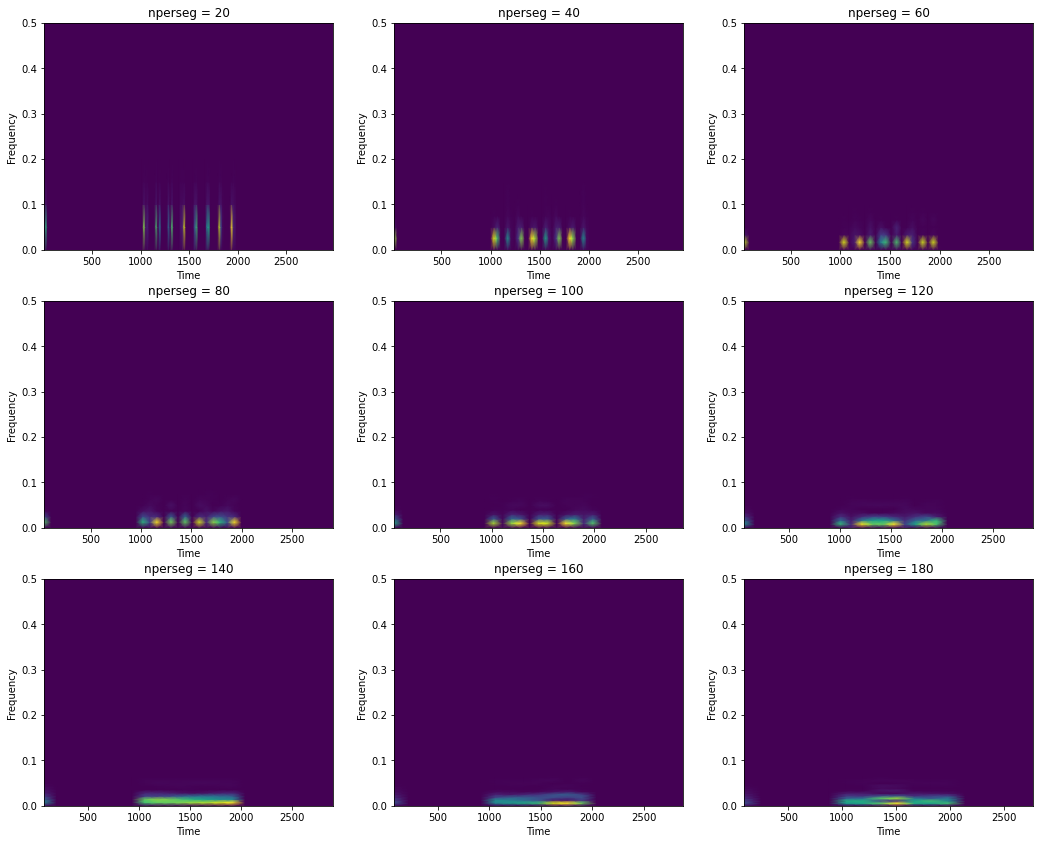

In [15]:
plot_spectrogram(stn_mean_firing_rate)#, filename="power_spectrum_STN.pdf")

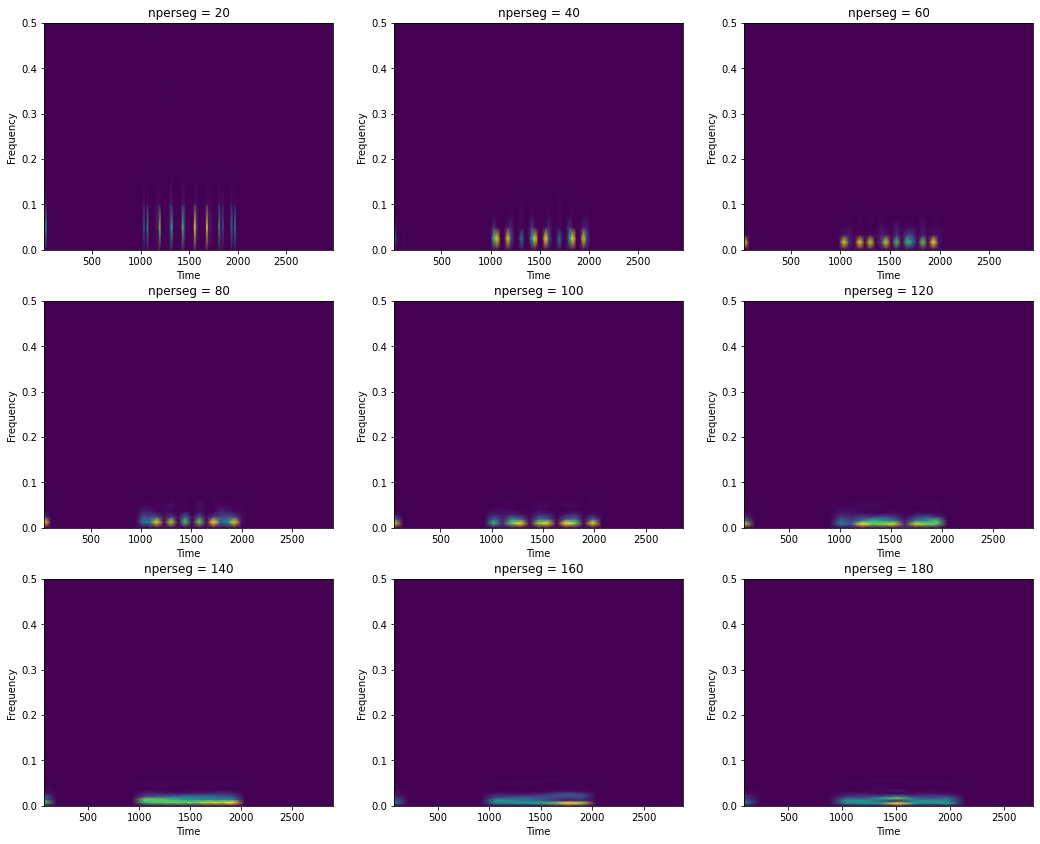

In [16]:
plot_spectrogram(gpe_mean_firing_rate)#, filename="power_spectrum_GPe.pdf")

# Autocorrelation

In [17]:
def autocorrelation(data):
    """
    Computes autocorrelation for the `data`.
    """
    
    var = np.var(data)
    data -= np.mean(data)
    
    acorr = np.correlate(data, data, 'full')
    
    return acorr / var / len(data)

In [18]:
def plot_autocorrelation(stn, gpe, event_times, event_labels=None, filename=None):
    """
    Plots autocorrelation for both `stn` and `gpe` and for all events divided by intervals specified in `event_times`.
    """
    
    ncols = 2
    nrows = len(event_times) - 1
    
    if event_labels == None:
        event_labels = ["" for i in range(nrows)]

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 12))
    fig.tight_layout(pad=3.0)

    for i in range(nrows):
        acorr_stn = autocorrelation(stn[event_times[i]:event_times[i+1]])
        acorr_gpe = autocorrelation(gpe[event_times[i]:event_times[i+1]])

        ax_stn = axes[i, 0]
        ax_stn.plot(np.arange(-len(acorr_stn) // 2, len(acorr_stn) // 2), acorr_stn, label='STN', color='#1f77b4')
        ax_stn.set_title(f'Autocorrelation of STN - {event_labels[i]}')
        ax_stn.legend()
        
        ax_gpe = axes[i, 1]
        ax_gpe.plot(np.arange(-len(acorr_gpe) // 2, len(acorr_gpe) // 2), acorr_gpe, label='GPe', color='#ff7f0e')
        ax_gpe.set_title(f'Autocorrelation of GPe - {event_labels[i]}')
        ax_gpe.legend()
        
        ax_stn.set_xlabel('Lag')
        ax_gpe.set_xlabel('Lag')
        ax_stn.set_ylabel('Autocorrelation')

    if filename:
        plt.savefig(filename)

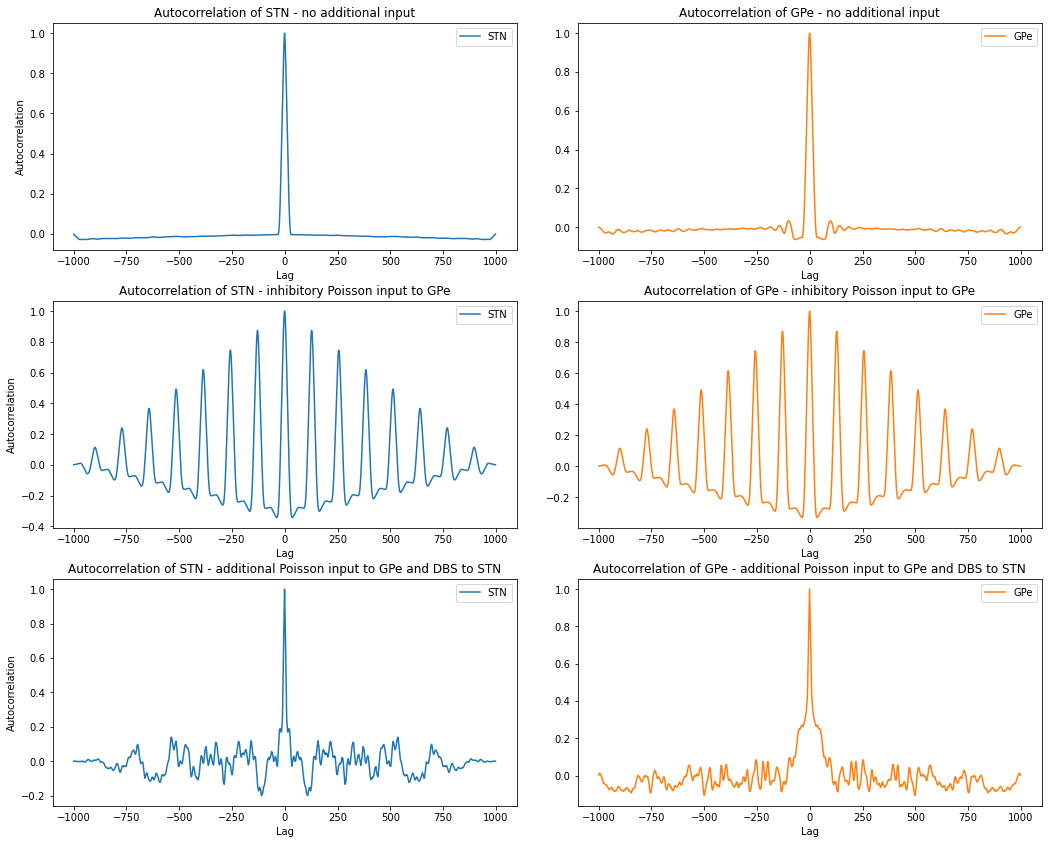

In [19]:
event_times = [0, gpe_start, dbs_start, SIM_LENGTH]
event_labels = ["no additional input", "inhibitory Poisson input to GPe", "additional Poisson input to GPe and DBS to STN"]

plot_autocorrelation(stn_mean_firing_rate, gpe_mean_firing_rate, event_times, event_labels=event_labels)#, filename="autocorrelation.pdf")

# Different Amplitudes of DBS


Jun 25 22:30:27 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jun 25 22:30:27 NodeManager::prepare_nodes [Info]: 
    Preparing 807 nodes for simulation.

Jun 25 22:30:27 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 807
    Simulation time (ms): 3000
    Number of OpenMP threads: 1
    Number of MPI processes: 1

Jun 25 22:30:29 SimulationManager::run [Info]: 
    Simulation finished.

Jun 25 22:30:29 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jun 25 22:30:29 NodeManager::prepare_nodes [Info]: 
    Preparing 807 nodes for simulation.

Jun 25 22:30:29 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 807
    Simulation time (ms): 3000
    Number of OpenMP threads: 1
    Number of MPI processes: 1

Jun 25 22:30:31 SimulationManager::run [Info]: 
    Simulation finished.

Jun 25 22:30:31 SimulationManager::set_status [Info]: 
    Temporal resolutio

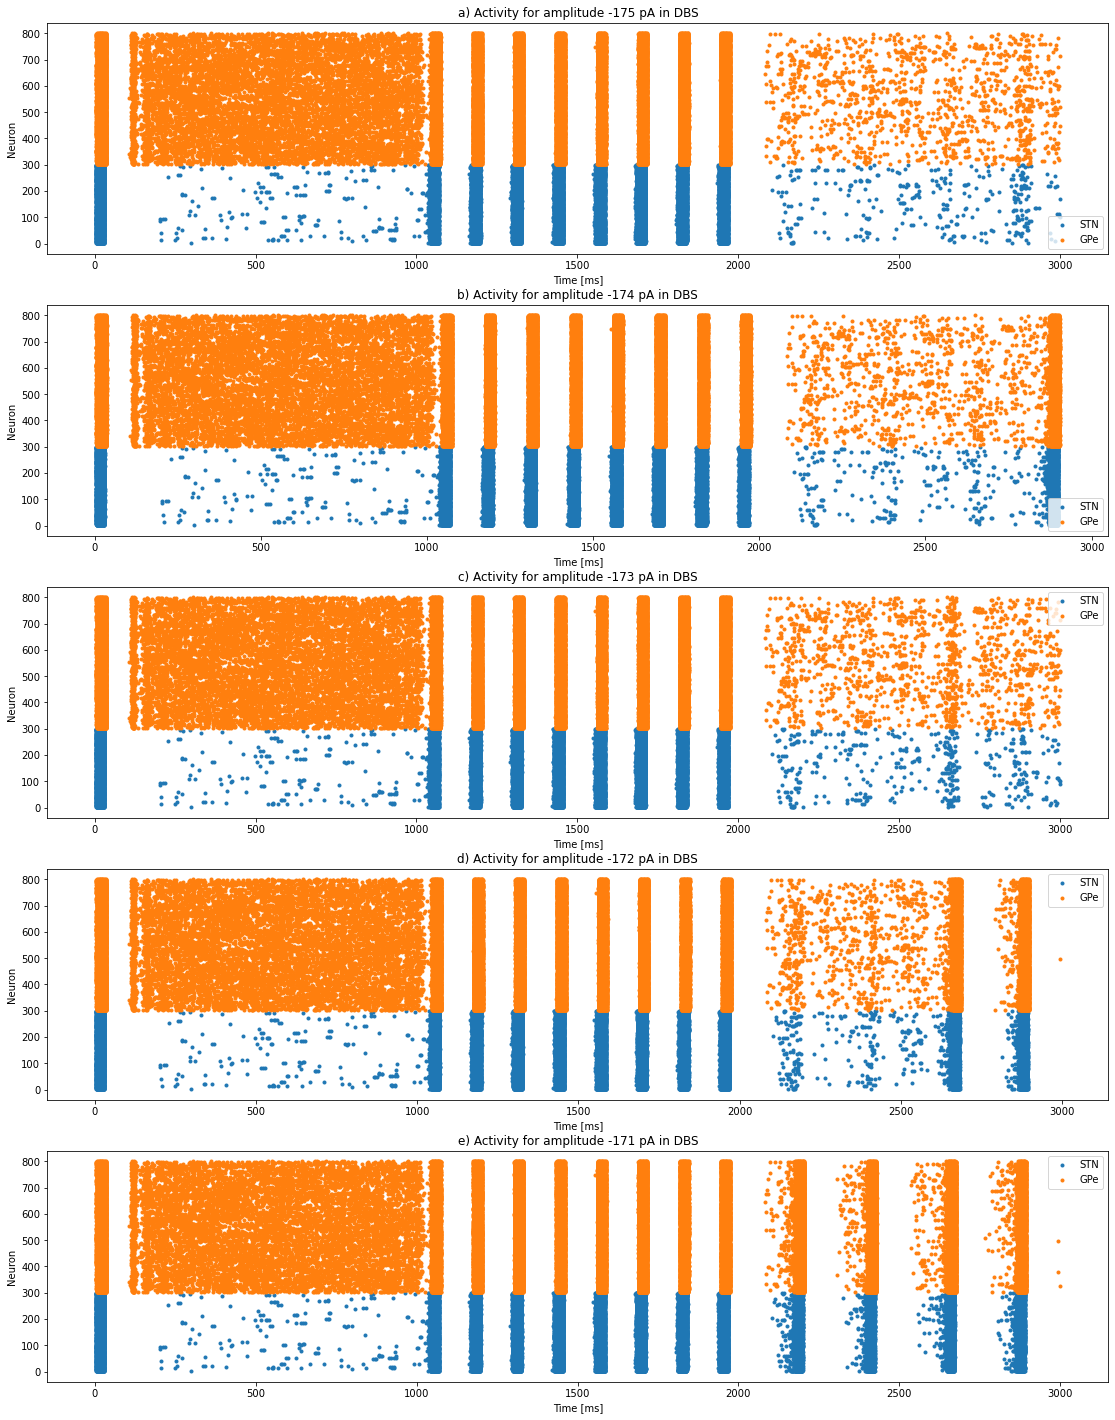

In [20]:
# amplitude_range = range(-200, -150, 10)
amplitude_range = range(-175, -170, 1)
labels = ['a', 'b', 'c', 'd', 'e']

fig, axes = plt.subplots(nrows=len(amplitude_range), ncols=1, figsize=(16, 4*len(amplitude_range)))
fig.tight_layout(pad=3.0)

for i, amplitude in enumerate(amplitude_range):
    simulator = NEST_simulator()
    simulator.dc1.amplitude = amplitude
    stn, gpe, _, _ = run_simulation()

    ax = axes[i] if len(amplitude_range) > 1 else axes
    plot_raster_neuronal_activity(stn, gpe, ax=ax, title=f"{labels[i]}) Activity for amplitude {amplitude} pA in DBS")

# plt.show()
# plt.savefig("different_dbs_amplitudes.pdf")
# plt.savefig("different_dbs_amplitudes_specific.pdf")